# 摘要

# 理论模型

甲醇，又名木精、木醇，英文名为 Methanol 或 MethylAlcohol，化学分子式为 $\rm{CH_3OH}$，为无色、略带醇香气味的挥发性液体，沸点 64.5-64.7℃，能溶于水，在汽油中有较大的溶解度，有毒、易燃，其蒸汽与空气能形成爆炸混合物。甲醇是由合成气生产的重要化学品之一，既是重要的化工原料，也是一种燃料。

![甲醇](.\images\甲醇.PNG)

## 分类

甲醇有工业甲醇、燃料甲醇和变性甲醇之分，目前以工业甲醇为主。
* 工业甲醇：凡是以煤、焦、天然气、轻油、重油等为原料合成的，其质量指标符合国标GB338-2004要求的，都是工业甲醇。随着可再生资源的开发利用，利用农作物秸秆、速生林木及林木废弃物、城市有机垃圾等也可以气化合成甲醇。
* 燃料甲醇：粗甲醇经脱水精制后作为燃料使用的无水甲醇。燃料甲醇未加变性剂，成本往往要比工业甲醇低，因为对它只有可燃烧和无水的要求。
* 变性甲醇是加入了甲醇变性剂的燃料甲醇或工业甲醇。因为甲醇和汽油、柴油不互溶，尤其在低温潮湿环境中发生分层（相分离）现象而造成发动机不能正常工作，因此燃料甲醇（或工业甲醇）变性后才能加入汽油、柴油中使用。变性燃料甲醇是在工业用甲醇中加入一定比例的车用甲醇汽油添加剂后，专门用于调配车用甲醇汽油的甲醇。


# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from WindPy import w
import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

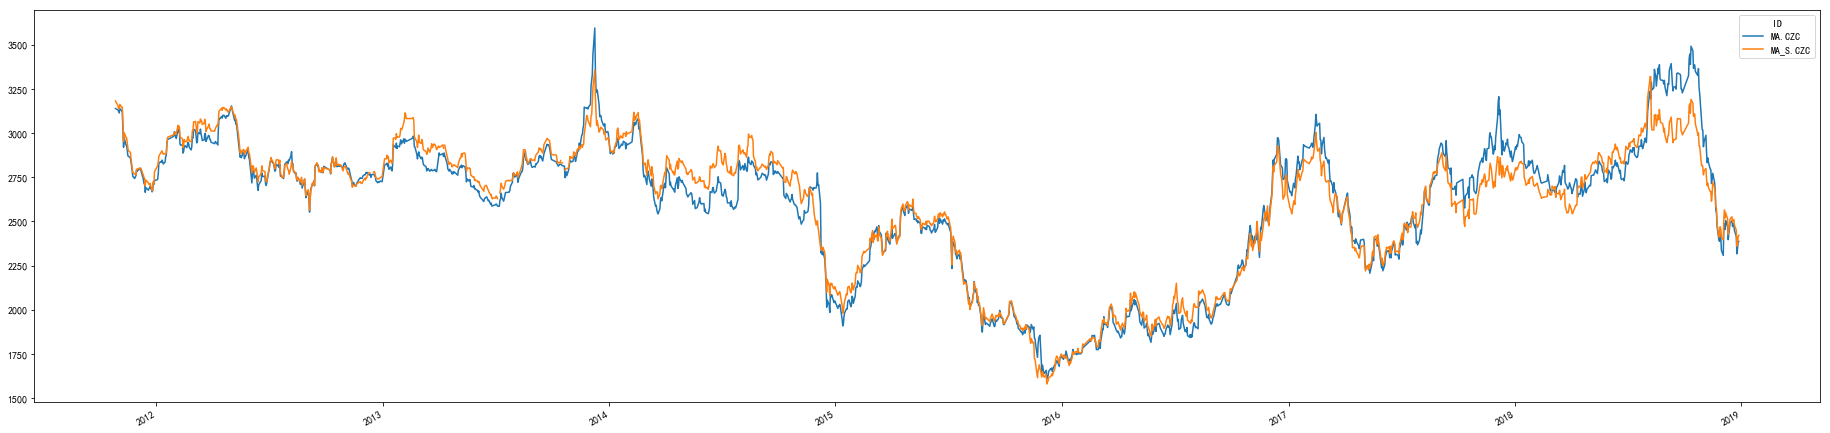

In [2]:
# 参数设置和数据准备
Exchange = "CZCE"
MID, SID = "MA.CZC", "MA_S.CZC"# 主力合约, 次主力合约
StartDT = dt.datetime(2011, 10, 28)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID, SID], dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=[PriceFactor], ids=FutureIDMap.columns.tolist(), dts=DTs).iloc[0]
WDB.disconnect()
# 对连续合约的价格进行调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CCPrice.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]

Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes);

# 附录

## 期货合约

![甲醇期货合约](.\images\甲醇期货合约.PNG)

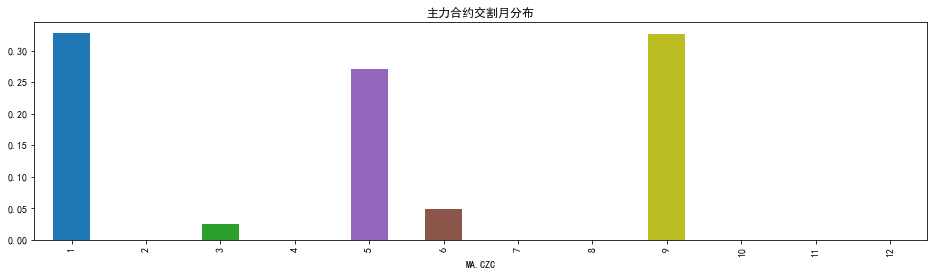

In [4]:
# 获取主力合约的月合约的交割月分布
import re
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
ExpiryMonthDistribution = ExpiryMonth.groupby(by=ExpiryMonth).count() / ExpiryMonth.shape[0]
ExpiryMonthDistribution = ExpiryMonthDistribution.loc[np.arange(1, 13)].fillna(0)
ExpiryMonthDistribution.plot(kind="bar", figsize=(16, 4), title="主力合约交割月分布");

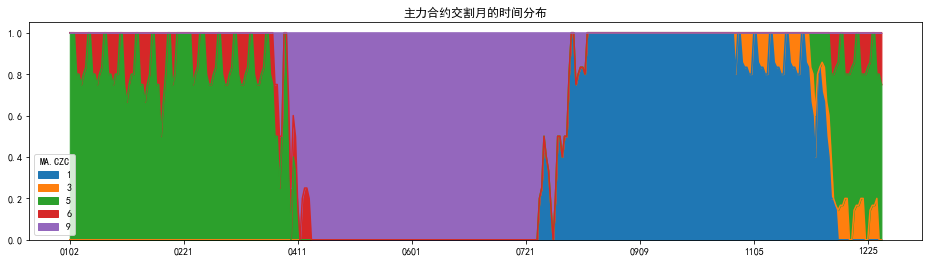

In [5]:
# 获取主力合约切换的时间分布
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
MonthDay = pd.Series([iDT.strftime("%m%d") for iDT in ExpiryMonth.index], index=ExpiryMonth.index)
ExpiryMonthDistributionPerYear = ExpiryMonth.groupby(by=[ExpiryMonth, MonthDay]).count().unstack()
ExpiryMonthDistributionPerYear = (ExpiryMonthDistributionPerYear / ExpiryMonth.groupby(by=MonthDay).count()).T
ExpiryMonthDistributionPerYear = ExpiryMonthDistributionPerYear.fillna(0)
Fig, Axes = plt.subplots(1, 1, figsize=(16, 4))
Axes = ExpiryMonthDistributionPerYear.plot(kind="area", ax=Axes, title="主力合约交割月的时间分布")
xTicks = Axes.get_xticks().astype(np.int)
xTickLabels = np.full(shape=xTicks.shape, fill_value="", dtype="O")
Mask = ((xTicks>=0) & (xTicks<ExpiryMonthDistributionPerYear.shape[0]))
xTickLabels[Mask] = ExpiryMonthDistributionPerYear.index.values[xTicks[Mask].tolist()]
Axes.set_xticklabels(xTickLabels);